In [66]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import Fully_connected_network as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [67]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

torch.manual_seed(15)
torch.set_default_dtype(torch.float64)

Running on the GPU


In [68]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [69]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [78]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        self.u_scale = torch.max(torch.abs(u_train))/2
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func) 
        self.model_optimizer = 'defined in train'
        self.loss_criterion = 'defined in train'

    def _adam_train(self, n_iter):
        loss_criterion = self.loss_criterion
        model_optimizer = self.model_optimizer

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train) * self.loss_scale
            loss_value.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def _closure(self):
        self.model_optimizer.zero_grad()
        u_pred = self.model(self.x_train)
        loss_value = self.loss_criterion(u_pred, self.u_train) * self.loss_scale
        loss_value.backward()
        return loss_value
    
    def _lbfgs_train(self, n_iter):
        for iter_i in range(n_iter):
            loss_value = self.model_optimizer.step(self._closure)
            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def train(self, n_iter, method):
        self.loss_criterion = torch.nn.MSELoss()
        if method == 1:
            self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
            self._adam_train(n_iter)
        elif method == 2:
            self.model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.1, max_iter=n_iter//3, tolerance_grad=1e-11, line_search_fn='strong_wolfe')
            self._lbfgs_train(n_iter)

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred



In [79]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1)
u_eval = u_exact(x_eval)

In [80]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(5000, 1)
model1.train(1000, 2)
u_pred = model1.predict(x_eval)

RuntimeError: grad can be implicitly created only for scalar outputs

In [73]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train).detach()
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(10000, 1)
model2.train(1000, 2)
u_pred2 = model2.predict(x_eval)
u_p = u_pred + u_pred2

Iteration 0, Loss: 3.400227028614371
Iteration 100, Loss: 0.03052320735239094
Iteration 200, Loss: 0.007086601407032147
Iteration 300, Loss: 0.002953764943600745
Iteration 400, Loss: 0.0015133476100308017
Iteration 500, Loss: 0.000859837355799898
Iteration 600, Loss: 0.000544207416427578
Iteration 700, Loss: 0.0003787244734351081
Iteration 800, Loss: 0.00028148760963137665
Iteration 900, Loss: 0.00021828119386615346
Iteration 1000, Loss: 0.00017418252025028062
Iteration 1100, Loss: 0.00014191342051105916
Iteration 1200, Loss: 0.00011750669049885351
Iteration 1300, Loss: 9.862687121629212e-05
Iteration 1400, Loss: 8.380870881608023e-05
Iteration 1500, Loss: 7.206787533145714e-05
Iteration 1600, Loss: 6.269722697014168e-05
Iteration 1700, Loss: 5.516199789675975e-05
Iteration 1800, Loss: 4.904619739739117e-05
Iteration 1900, Loss: 4.4023820184591496e-05
Iteration 2000, Loss: 3.9841094263848226e-05
Iteration 2100, Loss: 3.630324547423597e-05
Iteration 2200, Loss: 3.326318501867153e-05
Ite

In [74]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach()
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(5000, 1)
model3.train(1000, 2)
u_pred3 = model3.predict(x_eval)
u_p2 = u_p + u_pred3

Iteration 0, Loss: 5.216123275218959
Iteration 100, Loss: 0.04372812508627417
Iteration 200, Loss: 0.011514128272602116
Iteration 300, Loss: 0.004355767201703056
Iteration 400, Loss: 0.0021902383089300774
Iteration 500, Loss: 0.0012765508457433683
Iteration 600, Loss: 0.0008119403155768773
Iteration 700, Loss: 0.000553606978979246
Iteration 800, Loss: 0.0004032214770949743
Iteration 900, Loss: 0.00031248915487281384
Iteration 1000, Loss: 0.0002551940507100853
Iteration 1100, Loss: 0.00021671325827598827
Iteration 1200, Loss: 0.00018899259840793542
Iteration 1300, Loss: 0.00016769634678529165
Iteration 1400, Loss: 0.00015051138883276518
Iteration 1500, Loss: 0.00013617291241328818
Iteration 1600, Loss: 0.00012394265124422824
Iteration 1700, Loss: 0.00011334934917096624
Iteration 1800, Loss: 0.00010406609244987136
Iteration 1900, Loss: 9.585238217260468e-05
Iteration 2000, Loss: 8.852486972658678e-05
Iteration 2100, Loss: 8.194074101480341e-05
Iteration 2200, Loss: 7.598714079010556e-05


In [75]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(5000, 1)
model4.train(1000, 2)
u_pred4 = model4.predict(x_eval)

u_p3 = u_p2 + u_pred4

Iteration 0, Loss: 1.3952908799750106
Iteration 100, Loss: 0.1500384990640151
Iteration 200, Loss: 0.05184522828998745
Iteration 300, Loss: 0.015782247371389495
Iteration 400, Loss: 0.004343829541673091
Iteration 500, Loss: 0.001600464136171789
Iteration 600, Loss: 0.0010522590300069059
Iteration 700, Loss: 0.0005123084217729005
Iteration 800, Loss: 0.0005018406882136145
Iteration 900, Loss: 0.0002547282464988168
Iteration 1000, Loss: 0.00019943190063345873
Iteration 1100, Loss: 0.00017485752341593334
Iteration 1200, Loss: 0.0006836684573121016
Iteration 1300, Loss: 0.00015713053772405778
Iteration 1400, Loss: 9.5445007539422e-05
Iteration 1500, Loss: 8.66862425919196e-05
Iteration 1600, Loss: 0.0005873152375293559
Iteration 1700, Loss: 0.0003921142105780325
Iteration 1800, Loss: 0.00020378285166470307
Iteration 1900, Loss: 5.1133890261834135e-05
Iteration 2000, Loss: 0.0005320268862168658
Iteration 2100, Loss: 0.0006651925920024124
Iteration 2200, Loss: 0.00046183623802458965
Iteratio

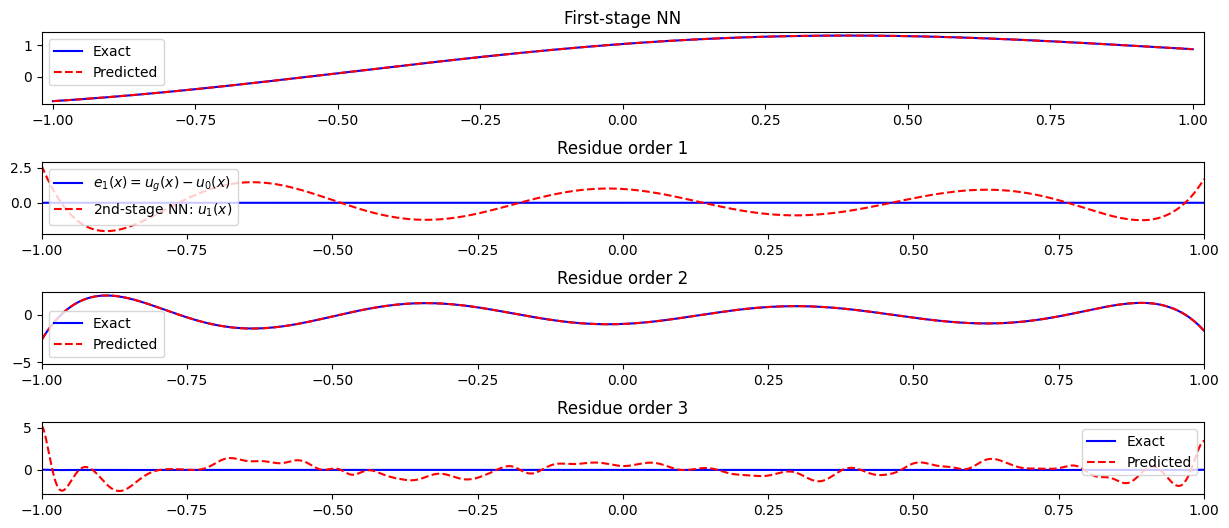

In [76]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_eval, u_eval, 'b-', label='Exact')
axes[0].plot(x_eval, u_pred.detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain, up_bound_xtrain)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train, u_train2.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval, u_pred2.detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening, u_train3, 'b-', label='Exact')
axes[2].plot(x_eval, u_pred3.detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening, u_train4.detach(), 'b-', label='Exact')
axes[3].plot(x_eval, u_pred4.detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [77]:
import numpy as np 
error_u = np.linalg.norm(u_eval - u_pred.detach())/np.linalg.norm(u_eval, 2)
error_u2 = np.linalg.norm(u_eval - u_p2.detach())/np.linalg.norm(u_eval, 2)
error_u3 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)
error_u4 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0005082085136286896
Error of order 2: 0.005527004366581709
Error of order 3: 0.9761281691808594
Error of order 4: 0.9761281691808594
